# GMODuck
A genetically modified yellow qantum duck who is competing in QHack 2021 Open Hackathon. This duck is capable of building QML circuits using genetic programming without having any idea why his model works but he assures it's the best.

## Setup

In [1]:
import sys
print (sys.version)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Comment this out if you don't want to install sklearn from this notebook
!pip install sklearn

In [3]:
# Imports
import random
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics

np.random.seed(42)

In [4]:
dev = qml.device('default.qubit', wires=2)

## Data

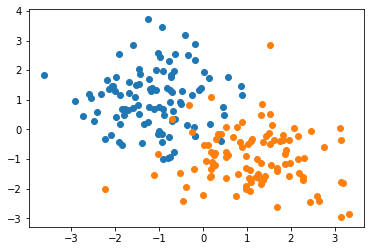

In [5]:
# This Data example is copied from the CERN workshop
n_samples = 200
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(int(n_samples/2)), np.ones(int(n_samples/2))], axis=0)
data = list(zip(X, Y))

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)
data_train = list(zip(X_train, y_train))
data_test  = list(zip(X_test, y_test))

In [6]:
# Init conditions
#in_str = None
#in_str_len = None
in_str = '01011011'
in_str_len = len(in_str)
population = 6
generations = 25
threshold = 0.96

## Quantum model

In [7]:
# Build a quantum model

genome = "01011011"
@qml.qnode(dev)
def quantum_model(x,w):
    # Encoding
    encode_gene = genome[:2]
    if encode_gene == "00" or "11":
        qml.templates.AngleEmbedding(x, wires=[0, 1])
    elif encode_gene == "01":
        qml.templates.AmplitudeEmbedding(x, wires=[0, 1],pad=1,normalize=True)
    elif encode_gene == "10":
        qml.templates.IQPEmbedding(x, wires=[0, 1])
    
    RZ_gene = genome[2:4]
    if RZ_gene == "01":
        qml.RZ(0.1,wires=0)
    elif RZ_gene == "10":
        qml.RZ(0.1,wires=1)
    elif RZ_gene == "11":
        qml.RZ(0.1,wires=0)
        qml.RZ(0.1,wires=1)
    
    Entanglement_gene = genome[4:5]
    if Entanglement_gene == "1":
        qml.templates.BasicEntanglerLayers(w, wires=[0, 1])

    T_gene = genome[5:7]
    if T_gene == "01":
        qml.T(wires=0)
    elif T_gene == "10":
        qml.T(wires=1)
    elif T_gene == "11":
        qml.T(wires=0)
        qml.T(wires=1)

    CNOT_gene = genome[7:8]
    if Entanglement_gene == "1":
        qml.CNOT(wires=[0,1])
        
    return qml.expval(qml.PauliZ(wires=0))


In [8]:
# Cost function
def loss(a, b):
    return (a - b)**2

def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = quantum_model(x, w)
        c += loss(prediction, y)
    return c/len(data)

# Gradient
gradient_fn = qml.grad(average_loss, argnum=0)

# Trainning
w_init = np.array([[1.1, -2], [2, -1], [-2, 1]])

w = np.array(w_init)

history = []
loss_train = []
loss_test = []

for i in range(15):
    w_new = w - 0.3*gradient_fn(w, data_train)
    avg_loss = average_loss(w_new, data_train)
    loss_train.append(avg_loss)
    print(avg_loss)
    history.append(w_new)
    w = w_new
    
    avg_loss_test = average_loss(w_new, data_test)
    loss_test.append(avg_loss_test)

1.0640670810829451
0.9319343105413028
0.8553870501458555
0.7661233123854125
0.6624063966576083
0.5659858962164276
0.4967868926883953
0.4563237341052468
0.43465505866269927
0.4226753950519475
0.4153887915525575
0.41051299000055
0.4070180437252484
0.40439690194013883
0.40236888329265624


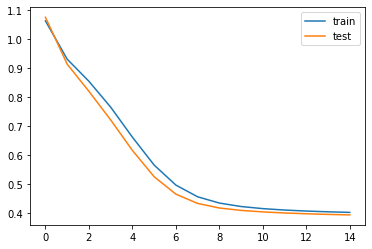

In [9]:
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend(loc="upper right")

In [10]:
def avail(w):
    count = 0
    for x, y in data:
        prediction = quantum_model(x, w)
        #print("pred: ",prediction,"; y   : ", y)
        if(prediction < 0):
            prediction = -1
        else:
            prediction = 1
        if prediction != y:
           count += 1
    print(count)
    
def pred(w,X):
    y_pred = []
    for x in X:
        prediction = quantum_model(x, w)
        y_pred.append(prediction)
        
    return y_pred

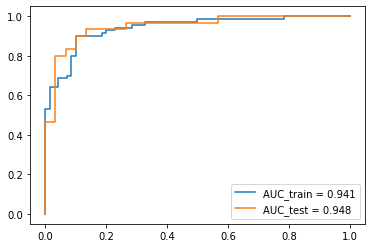

In [11]:
y_pred_train = pred(w,X_train)
y_pred_test  = pred(w,X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)

roc_auc_train = metrics.auc(fpr_train,tpr_train)
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr_train,tpr_train, label='AUC_train = %0.3f' % (roc_auc_train))
plt.plot(fpr,tpr, label='AUC_test = %0.3f' % (roc_auc))
plt.legend(loc="lower right")

In [12]:
print(quantum_model.draw())

 0: ──RX(1.2)───RZ(0.1)──RX(0.732)──╭C──RX(0.445)──╭C──RX(-2.37)──╭C──T──╭C──┤ ⟨Z⟩ 
 1: ──RX(-1.6)──RX(-2)──────────────╰X──RX(-1)─────╰X──RX(1)──────╰X─────╰X──┤     



In [13]:
print("\U0001F986 Qhack Qhack") 

🦆 Qhack Qhack
